In [1]:
import pyautogui
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
import math
import cv2

/home/jnu/anaconda3/envs/jupyter/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# DQN 모델 정의
class DQN(nn.Module):
    def __init__(self,num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 16, 3, stride=2, padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 64, 3, stride=2, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(nn.Conv2d(64, 256, 3, stride=2, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(inplace=True))
        self.conv4 = nn.Sequential(nn.Conv2d(256, 512, 3, stride=2, padding=1),
                                   nn.BatchNorm2d(512),
                                   nn.ReLU(inplace=True))
        self.actor_linear = nn.Sequential(nn.Linear(933888, 256),
                                          nn.ReLU(inplace=True),
                                          nn.Linear(256,num_actions))

    def forward(self, x): #각 action에 대한 가치를 softmax를 거쳐서 확률로 출력
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.actor_linear(x.reshape(x.size(0), -1))
        return x

In [3]:
x_list=[]
y_list=[]
for i in range(14):
    y_list.append(508+(19*i))
for i in range(18):
    x_list.append(791+(24*i))
    action_list=[(x,y) for x in x_list for y in y_list]
    action_list.append((900,900)) #1번 카드(252)
    action_list.append((1000,900)) #2번 카드(253)
    action_list.append((1100,900)) #3번 카드(254)
    action_list.append((1200,900)) #4번 카드(255)
    num_actions=len(action_list)

action_set={}
for i in range(num_actions):
    action_set[i]=action_list[i]

In [4]:
model=DQN(num_actions)
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)

gamma=0.9
epsilon=0.9
epochs=10

losses=[]

In [5]:
#게임 환경 클래스(state, reward, done 이 들어가야함)
class ENV:
    def __init__(self):
        self.done=0
        self.reward=0
        
    def get_state(self):
        screenshot=pyautogui.screenshot(region=(741,100,1250-741,999-100))
        screenshot.save('screenshot.png')
        screenshot = cv2.cvtColor(np.array(screenshot), cv2.COLOR_BGR2GRAY)
        state=np.array(screenshot)
        state=np.float32(state)/255.0
        state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=1)
        state = torch.from_numpy(state).float()
        #state=torch.from_numpy(state).unsqueeze(0).float()#3색
        #state=state.permute(0,3,1,2)#3색
        return state # state는 tensor이고 (1,3,509,899)

    def get_reward(self):
        screenshot=cv2.imread('screenshot.png')
        lose=cv2.imread('lose.png')
        win=cv2.imread('win.png')
        score_lose=cv2.matchTemplate(screenshot,lose,cv2.TM_CCOEFF_NORMED)
        score_win=cv2.matchTemplate(screenshot,win,cv2.TM_CCOEFF_NORMED)
        reward=0
        done=0 #게임 한 번
        if score_lose[0][0]>=0.9:
            reward-=3000000
            done=1
        
        #win 사진
        elif score_win[0][0]>=0.9:
            reward+=3000000
            done=1
            
        return reward, done
    
    #def select_action(self):
        

In [6]:
env=ENV()

for i in range(1):
    state1=env.get_state()
    reward,done=env.get_reward()[0],env.get_reward()[1]
    step=0
    times=[]
    fpss=[]
    
    while(done==0):
        start_time=time.time()
        qval=model(state1)
        qval_=qval.data.numpy()
        
        if (random.random()<epsilon):
            action_=np.random.randint(0,255)
        else:
            action_=np.argmax(qval_)
        
        action=action_set[action_] #action으로 좌표값 튜플형식으로 출력
        
        pyautogui.moveTo(action[0],action[1])
        pyautogui.click(button='left')
        
        state2=env.get_state()
        reward=env.get_reward()[0]
        
        with torch.no_grad():
            newQ=model(state2)
        maxQ=torch.max(newQ)
        
        # max Q 에 해당하는 좌표를 알기 위해 추가한 코드(이후에 지울 예정)
        newQ_=newQ.data.numpy()
        action_Q=np.argmax(newQ_)
        Q_action=action_set[action_Q]
        
        if reward == 0:
            Y=reward+(gamma*maxQ)
        else:
            Y=reward
        
        Y=torch.Tensor([Y]).detach()
        X=qval.squeeze()[action_]
        X=X.reshape(1)
        loss=F.smooth_l1_loss(X,Y)
        print(f'episode : {i}, click : {step}, loss : {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1=state2
        
        reward,done=env.get_reward()[0],env.get_reward()[1]
        
        end_time=time.time()
        diff_time=end_time-start_time
        fps=1.0/diff_time
        times.append(diff_time)
        fpss.append(fps)
        
        print(f'reward : {reward}, done : {done}')
        print(f'찍은 좌표 : {action} , max Q 값을 가지는 좌표 : {Q_action}')
        
        step+=1
        
        #if reward != -3000000:
            #done=1
        
    if epsilon>0.1:
        epsilon-=(1/epochs)

episode : 0, click : 0, loss : 0.1383974552154541
reward : 0, done : 0
찍은 좌표 : (911, 603) , max Q 값을 가지는 좌표 : (791, 717)
episode : 0, click : 1, loss : 17.94256591796875
reward : 0, done : 0
찍은 좌표 : (1127, 736) , max Q 값을 가지는 좌표 : (911, 603)
episode : 0, click : 2, loss : 37.15943145751953
reward : 0, done : 0
찍은 좌표 : (1031, 717) , max Q 값을 가지는 좌표 : (1127, 736)
episode : 0, click : 3, loss : 35.7967643737793
reward : 0, done : 0
찍은 좌표 : (959, 603) , max Q 값을 가지는 좌표 : (1127, 736)
episode : 0, click : 4, loss : 61.3748664855957
reward : 0, done : 0
찍은 좌표 : (863, 641) , max Q 값을 가지는 좌표 : (959, 603)
episode : 0, click : 5, loss : 56.49717712402344
reward : 0, done : 0
찍은 좌표 : (791, 622) , max Q 값을 가지는 좌표 : (959, 603)
episode : 0, click : 6, loss : 45.95130157470703
reward : 0, done : 0
찍은 좌표 : (1199, 546) , max Q 값을 가지는 좌표 : (959, 603)
episode : 0, click : 7, loss : 59.372623443603516
reward : 0, done : 0
찍은 좌표 : (791, 641) , max Q 값을 가지는 좌표 : (1199, 546)
episode : 0, click : 8, loss : 75.

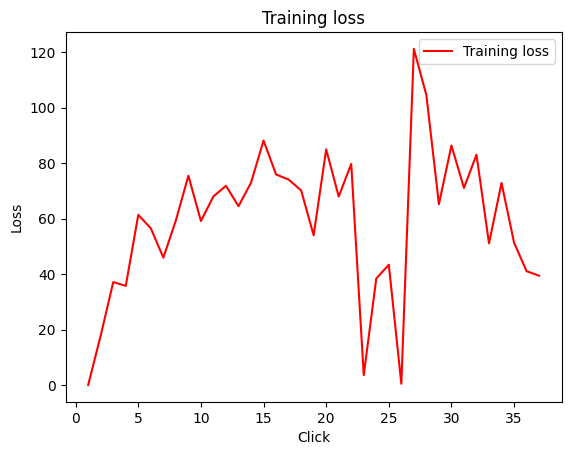

[0.1383974552154541, 17.94256591796875, 37.15943145751953, 35.7967643737793, 61.3748664855957, 56.49717712402344, 45.95130157470703, 59.372623443603516, 75.44471740722656, 59.12849807739258, 68.00088500976562, 71.82963562011719, 64.4608383178711, 72.94099426269531, 88.11729431152344, 75.89349365234375, 74.0560073852539, 70.16712188720703, 54.023155212402344, 84.94127655029297, 67.95318603515625, 79.684326171875, 3.6603546142578125, 38.44111633300781, 43.39508819580078, 0.5553779602050781, 121.09064483642578, 104.44078826904297, 65.19050598144531, 86.32989501953125, 71.03955841064453, 83.01954650878906, 51.08268356323242, 72.86444091796875, 51.35990905761719, 41.0633659362793, 39.46059036254883, 2999996.75]
loss mean : 59.29374118109007


In [7]:
steps = np.arange(1, step)
plt.plot(steps, losses[:-1], 'r', label='Training loss')
plt.title('Training loss')
plt.xlabel('Click')
plt.ylabel('Loss')
plt.legend()

plt.show()
print(losses)
print(f'loss mean : {np.mean(losses[:-1])}')

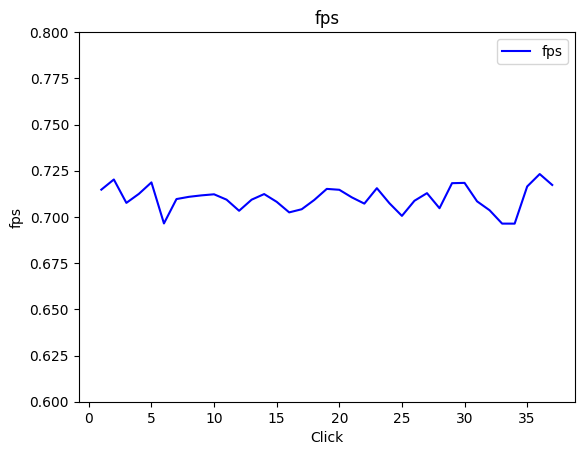

fps mean : 0.7099713516730694


In [10]:
steps = np.arange(1, step)
plt.plot(steps, fpss[1:], 'b', label='fps')
plt.title('fps')
plt.xlabel('Click')
plt.ylabel('fps')
plt.ylim(0.6,0.8)
plt.legend()

plt.show()
print(f'fps mean : {np.mean(fpss[1:])}')

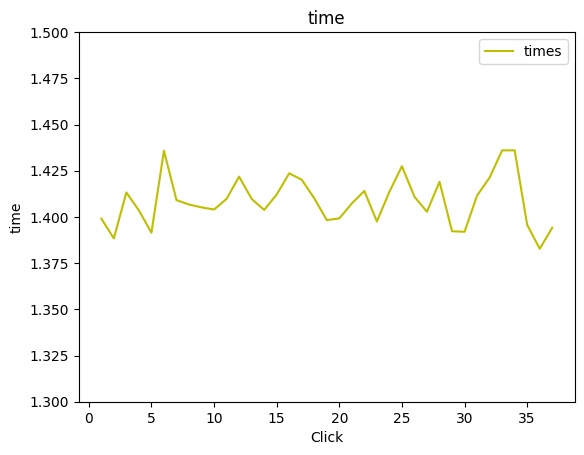

time mean : 1.4086285539575525


In [11]:
steps = np.arange(1, step)
plt.plot(steps, times[1:], 'y', label='times')
plt.title('time')
plt.xlabel('Click')
plt.ylabel('time')
plt.ylim(1.3,1.5)
plt.legend()

plt.show()
print(f'time mean : {np.mean(times[1:])}')